In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import cm, colors
from pprint import pprint
from scipy.ndimage import gaussian_filter1d
from IPython.display import display

# brainbox / iblatlas / ONE 관련
from brainbox.io.one import SessionLoader, SpikeSortingLoader
from brainbox.singlecell import bin_spikes
from brainbox.ephys_plots import plot_brain_regions
from iblatlas.atlas import AllenAtlas
from one.api import ONE

import os
import sys
sys.path.append('./v3_def')
from print_cluster_info import print_cluster_info
from get_trial_masks import get_trial_masks
from compute_raster import compute_raster
from plot_raster import plot_raster
from plot_psth_2x2 import plot_psth_2x2
from plot_psth_contrast import plot_psth_contrast
from sub_func import save_file

save_path = "Z:\ChaeHyeon_Seong"

In [ ]:
# -----------------------------------------------------------------------------
# 0. ONE 초기화 및 세션 검색(키워드 기반 유연한 brain_acronym)
# -----------------------------------------------------------------------------
one = ONE()
# 원하는 뇌영역 문자열을 지정(예: 'VISp', 'MOs' 등)
brain_acronym = 'VISp' # only Left Hemisphere

# 특정 뇌영역 관련 세션 검색
sessions = one.search(atlas_acronym=brain_acronym, query_type='remote')
print(f'\nNo. of detected sessions in {brain_acronym}: {len(sessions)}\n')
pprint(sessions[0:5])

# -----------------------------------------------------------------------------
# 1. eid <-> pid 변환 (세션 ID <-> 실험 ID)
# -----------------------------------------------------------------------------
# 특정 eid 선택
eid = 'ca4ecb4c-4b60-4723-9b9e-2c54a6290a53'
pids, labels = one.eid2pid(eid)
for pid, name in zip(pids, labels):
    print(f'pid: {pid}, pname: {name}')

# 관련 pid
pid = '92822789-608f-44a6-ad64-fe549402b2df'
# pid = 'c5b9e063-f640-4936-b851-f7602cb6659b'
eid, pname = one.pid2eid(pid)
print(f'eid: {eid}, pname: {pname}')

# -----------------------------------------------------------------------------
# 세션 선택
# -----------------------------------------------------------------------------
eid = 'ca4ecb4c-4b60-4723-9b9e-2c54a6290a53'
pid = one.eid2pid(eid)[0][0]


No. of detected sessions in VISp: 73

['5ae68c54-2897-4d3a-8120-426150704385',
 '6899a67d-2e53-4215-a52a-c7021b5da5d4',
 'ca4ecb4c-4b60-4723-9b9e-2c54a6290a53',
 '7dd27c2f-9544-448d-918d-be0f9837b0e0',
 'caa5dddc-9290-4e27-9f5e-575ba3598614']
pid: 92822789-608f-44a6-ad64-fe549402b2df, pname: probe00
eid: ca4ecb4c-4b60-4723-9b9e-2c54a6290a53, pname: probe00


In [ ]:
# -----------------------------------------------------------------------------
# 2. Trial data 로드 (load_object / SessionLoader)
# -----------------------------------------------------------------------------
# Trial 데이터 로드 방법 1
trials = one.load_object(eid, 'trials')

# Trial 데이터 로드 방법 2
sl = SessionLoader(eid=eid, one=one)
sl.load_trials()
events = sl.trials['stimOn_times'].values
left_idx, right_idx, correct_idx, incorrect_idx = get_trial_masks(sl.trials) # trial mask

# -----------------------------------------------------------------------------
trials_df = trials.to_df()
display(trials_df)  # 상위 몇개 미리보기

# trials_df 중 일부 컬럼만 선택하여 저장
trials_df = trials_df[['stimOn_times', 'contrastLeft', 'contrastRight', 'choice', 'feedbackType', 'response_times']]

# 2. trial information: stimulus onset time, stimulus contrast, stimulus location (e.g., left/right), stimulus size and orientation, mouse choice (left/right), reaction time etc.
save_file(trials_df, save_path, save_title="trials_info")


,goCueTrigger_times,stimOff_times,goCue_times,response_times,choice,stimOn_times,contrastLeft,contrastRight,probabilityLeft,feedback_times,feedbackType,rewardVolume,firstMovement_times,intervals_0,intervals_1
0,18.265063,19.599184,18.266063,18.526168,-1.0,18.365397,NaN,1.000,0.5,18.526282,1.0,1.5,18.364963,17.143841,20.099301
1,23.665450,25.032057,23.666450,23.965253,1.0,23.665315,0.25,NaN,0.5,23.965354,1.0,1.5,23.645963,20.761912,25.532176
2,28.282413,29.832021,28.283413,28.765920,-1.0,28.282295,NaN,0.250,0.5,28.766018,1.0,1.5,28.372963,26.219882,30.332146
3,32.232573,33.898551,32.233373,32.832782,-1.0,32.232436,NaN,0.125,0.5,32.832881,1.0,1.5,32.309963,30.944353,34.398608
4,35.582521,36.915843,35.583421,35.855823,-1.0,35.582398,NaN,0.250,0.5,35.855940,1.0,1.5,35.543963,35.016016,37.415938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615,3545.090054,3553.656329,3545.090854,3551.619542,-1.0,3545.089874,0.25,NaN,0.2,3551.620542,-1.0,0.0,3551.032963,3544.650948,3554.156379
616,3555.390193,3557.289765,3555.391193,3556.241702,-1.0,3555.390071,NaN,0.125,0.2,3556.241794,1.0,1.5,3555.592963,3554.856086,3557.789822
617,3558.873836,3561.223274,3558.874536,3559.159442,1.0,3558.873721,NaN,0.125,0.2,3559.160542,-1.0,0.0,3558.784963,3558.433128,3561.723293
618,3562.990612,3564.706491,3562.991512,3563.642222,-1.0,3562.990447,NaN,1.000,0.2,3563.642321,1.0,1.5,3563.152963,3562.365204,3565.206546


In [1]:
# -----------------------------------------------------------------------------
# 2. Spike data 로드 (SpikeSortingLoader)
# -----------------------------------------------------------------------------
# Spike Sorting 데이터
ssl = SpikeSortingLoader(one=one, pid=pid, atlas=AllenAtlas())
spikes, clusters, channels = ssl.load_spike_sorting()
clusters = ssl.merge_clusters(spikes, clusters, channels)

# -----------------------------------------------------------------------------
# 3. Cluster Mask 정의 (특정 영역(문자열 포함) & Good Cluster)
# -----------------------------------------------------------------------------
region_mask = np.array([brain_acronym in acr for acr in clusters['acronym']]) # ex) 'VISp1', 'VISp2', ...
good_cluster_mask = (clusters['label'] == 1)
selected_mask = region_mask & good_cluster_mask  # good clusters in region (ex. VISp)

clusters_good = {k: v[good_cluster_mask] for k, v in clusters.items()} # Good clusters만 추출

# -----------------------------------------------------------------------------
# 4. Clusters Info
# -----------------------------------------------------------------------------
# 4. 전체 클러스터 & Good 클러스터의 뇌 영역(Acronym) 통계
print_cluster_info(clusters, clusters_good, brain_acronym)

# 5. neuron information: hemisphere, area, layer, spike waveform (regular-spiking or fast-spiking)
# clusters_df를 생성하고, peakToTrough 값을 기준으로 spike waveform type을 구분
clusters_df = clusters.to_df()

# 예시 임계값 (ms): peakToTrough의 절대값이 임계값보다 작으면 fast-spiking, 그렇지 않으면 regular-spiking
threshold = 0.5  # 단위: ms (필요시 조정)
# peakToTrough가 음수일 수 있으므로 절대값을 사용합니다.
clusters_df['spikeType'] = clusters_df['peakToTrough'].abs().apply(
    lambda x: 'fast-spiking' if x < threshold else 'regular-spiking'
)

# clusters_df 확인 (상위 몇 개 행)
display(clusters_df.head())

# 파일 저장 (예시 경로에 맞게 수정)
save_file(clusters_df, save_path="Z:\\ChaeHyeon_Seong", save_title="neuron_info")


NameError: name 'SpikeSortingLoader' is not defined

In [6]:
# -----------------------------------------------------------------------------
# 1. psth (Nneurons X Ntrials X Ntimebins), where Ntimebins encompasses -2s to 4s relative to sensory onset, and each time bin is 1ms, i.e., 6000 time bins
spike_raster, times = compute_raster(spikes, selected_mask, events, pre_time=2, post_time=4, bin_size=0.001)
save_file(spike_raster, save_path, save_title="psth")

C:\Users\stell\AppData\Local\Temp\ipykernel_18508\1409774841.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


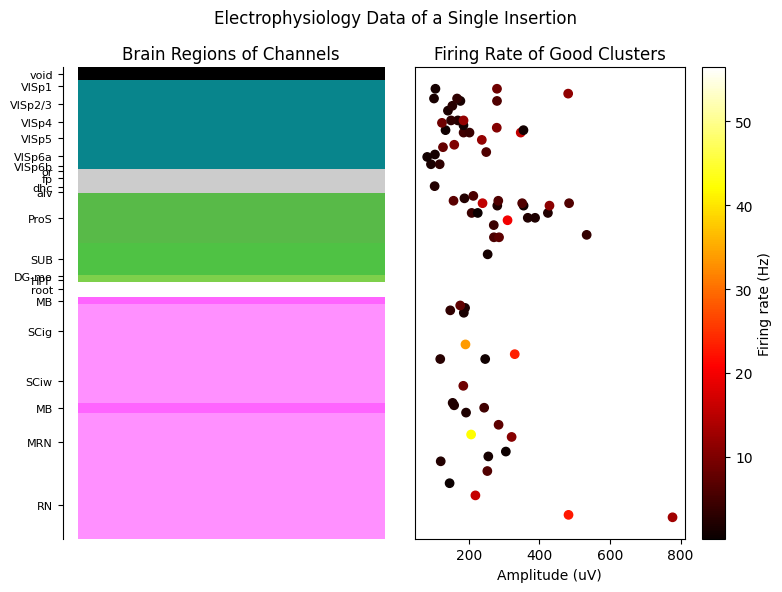

In [8]:
# -----------------------------------------------------------------------------
# 5. 뇌 위치 시각화 & 뇌 위치 별 Firing rate
# -----------------------------------------------------------------------------
firing_rate = clusters_good['firing_rate']
norm = colors.Normalize(vmin=np.min(firing_rate), vmax=np.max(firing_rate), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
firing_rate_cols = mapper.to_rgba(firing_rate)

fig, axs = plt.subplots(1, 2, figsize=(8, 6))
fig.suptitle('Electrophysiology Data of a Single Insertion')

# (좌) 채널의 Brain regions
plot_brain_regions(channels['atlas_id'], channel_depths=channels['axial_um'], ax=axs[0])
axs[0].set_title('Brain Regions of Channels')

# (우) 클러스터들의 (amp_median, depth) 산점도 + firing rate 컬러
axs[1].scatter(clusters_good['amp_median'] * 1e6,
               clusters_good['depths'],
               c=firing_rate_cols)
axs[1].set_xlabel('Amplitude (uV)')
axs[1].get_yaxis().set_visible(False)
axs[1].set_title('Firing Rate of Good Clusters')

cbar = fig.colorbar(mapper, ax=axs[1])
cbar.set_label('Firing rate (Hz)')

plt.tight_layout()